In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import random
from tqdm import tqdm
import geopy.distance

In [4]:
def read_data_from_db(file_path):
    conn = sqlite3.connect(file_path)

    try:
        cursor = conn.cursor()

        # Retrieve the first table name from the sqlite_master table
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table' LIMIT 1")
        result = cursor.fetchone()

        if result is None:
            print("No tables found in the database.")
            conn.close()
            return None

        table_name = result[0]

        # Read the data from the retrieved table
        query = f"SELECT * FROM {table_name}"
        data = pd.read_sql_query(query, conn)
        conn.close()
        return data

    except sqlite3.Error as e:
        print(f"An error occurred while reading the database: {e}")
        return None

In [5]:
def load_data(path):
    try:
        _, file_extension = os.path.splitext(path)

        if file_extension == ".csv":
            data = pd.read_csv(path)
        elif file_extension in [".xls", ".xlsx"]:
            data = pd.read_excel(path)
        elif file_extension in [".db", ".sql"]:
            data = read_data_from_db(path)

        else:
            raise ValueError(
                "Unsupported file format. Please provide a CSV, Excel, SQL, or SQLite database file."
            )

        return data

    except FileNotFoundError:
        print("File not found. Please provide a valid file path.")
        return None

    except pd.errors.ParserError:
        print(
            "Error occurred while parsing the file. Please check if the file format is correct."
        )
        return None

    except Exception as e:
        print("An error occurred while loading the data:", str(e))
        return None

In [46]:
# Get data ready 
def preprocess_data(data):
    # Select relevant columns for analysis (e.g., price, availability, latitude, longitude, property type)
    selected_columns = [
        "price",
        "availability_365",
        "latitude",
        "longitude",
        "room_type",
    ]
    data = data[selected_columns]

    # Handle missing values in numerical columns
    data.loc[:, "price"] = data["price"].fillna(data["price"].mean())
    data.loc[:, "availability_365"] = data["availability_365"].fillna(data["availability_365"].mean())

    # Handle missing values in latitude and longitude columns
    data.loc[:, "latitude"] = data["latitude"].fillna(data["latitude"].mean())
    data.loc[:, "longitude"] = data["longitude"].fillna(data["longitude"].mean())

    # Calculate location based on latitude and longitude
    def get_location(lat, lon):
        return geopy.distance.geodesic((lat, lon), (reference_lat, reference_lon)).km

    reference_lat = data["latitude"].mean()
    reference_lon = data["longitude"].mean()
    data["location"] = data.apply(
        lambda row: get_location(row["latitude"], row["longitude"]), axis=1
    )

    return data

In [22]:
def visualize_histogram(data, header_name):
    plt.figure(figsize=(12, 8))

    if header_name in data.columns:
        column_data = data[header_name]

        if column_data.dtype == "object":
            # Categorical column visualization
            value_counts = column_data.value_counts()

            sns.barplot(x=value_counts.index, y=value_counts.values)
            plt.title(f"{header_name} Histogram")
            plt.xlabel(header_name)
            plt.ylabel("Count")

            # Display value counts on the plot
            for i, count in enumerate(value_counts.values):
                plt.text(i, count, str(count), ha="center", va="bottom")

            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            print(f"\nValue counts for column '{header_name}':")
            print(value_counts)
        else:
            # Numerical column visualization
            sns.histplot(
                column_data, kde=True, color=random.choice(list(sns.color_palette()))
            )
            plt.title(f"{header_name} Histogram")
            plt.xlabel(header_name)
            plt.ylabel("Frequency")

            # Display descriptive statistics
            descriptive_stats = column_data.describe()
            print(f"\nDescriptive statistics for column '{header_name}':")
            print(descriptive_stats)
            plt.tight_layout()
            plt.show()
    else:
        print(f"Column '{header_name}' does not exist in the data.")

In [23]:
def visualize_boxplot(data, x_column, y_column):

    visualization_name = "Boxplot"

    # Display progress bar
    with tqdm(total=len(data)) as pbar:
        plt.figure(figsize=(8, 6))

        if data[x_column].dtype == "object":
            # Categorical x column and numerical y column
            unique_x = data[x_column].unique()
            colors = random.choices(list(sns.color_palette("Set3", len(unique_x))))

            sns.boxplot(data=data, x=x_column, y=y_column, palette=colors)
            plt.title(f"{x_column} vs {y_column} {visualization_name}")
            plt.xlabel(x_column)
            plt.ylabel(y_column)

        elif data[y_column].dtype == "object":
            # Numerical x column and categorical y column
            unique_y = data[y_column].unique()
            colors = random.choices(list(sns.color_palette("Set3", len(unique_y))))

            sns.boxplot(data=data, x=x_column, y=y_column, palette=colors)
            plt.title(f"{x_column} vs {y_column} {visualization_name}")
            plt.xlabel(x_column)
            plt.ylabel(y_column)

        else:
            # Numerical x and y columns
            sns.boxplot(data=data, x=x_column, y=y_column)
            plt.title(f"{x_column} vs {y_column} {visualization_name}")
            plt.xlabel(x_column)
            plt.ylabel(y_column)

        plt.tight_layout()
        plt.show()

        pbar.update(len(data))

In [24]:
def visualize_scatterplot(data, x_column, y_column):
    visualization_type = "Scatterplot"

    # Display progress bar
    with tqdm(total=len(data)) as pbar:
        plt.figure(figsize=(8, 6))

        if data[x_column].dtype == "object" and data[y_column].dtype == "object":
            # Categorical x and y columns
            unique_x = data[x_column].unique()
            unique_y = data[y_column].unique()
            colors_x = random.choices(list(sns.color_palette("Set3", len(unique_x))))
            colors_y = random.choices(list(sns.color_palette("Set3", len(unique_y))))

            sns.scatterplot(
                data=data, x=x_column, y=y_column, hue=x_column, palette=colors_x
            )

        elif data[x_column].dtype == "object":
            # Categorical x column and numerical y column
            unique_x = data[x_column].unique()
            colors = random.choices(list(sns.color_palette("Set3", len(unique_x))))

            sns.stripplot(
                data=data, x=x_column, y=y_column, hue=x_column, palette=colors
            )

        elif data[y_column].dtype == "object":
            # Numerical x column and categorical y column
            unique_y = data[y_column].unique()
            colors = random.choices(list(sns.color_palette("Set3", len(unique_y))))

            sns.stripplot(
                data=data, x=x_column, y=y_column, hue=y_column, palette=colors
            )

        else:
            # Numerical x and y columns
            sns.scatterplot(data=data, x=x_column, y=y_column)

        plt.title(f"{x_column} vs {y_column} {visualization_type}")
        plt.xlabel(x_column)
        plt.ylabel(y_column)
        plt.tight_layout()
        plt.show()

        pbar.update(len(data))

In [57]:
def visualize_pie_chart(data, column):
    visualization_type = "Pie Chart"

    # Count the occurrences of each unique value in the column
    value_counts = data[column].value_counts()

    # Get the labels and corresponding counts
    labels = value_counts.index
    counts = value_counts.values

    # Create a pie chart
    plt.figure(figsize=(12, 8))
    plt.pie(
        counts,
        labels=labels,
        autopct="%1.1f%%",
        startangle=90,
        colors=sns.color_palette("Set3"),
    )

    # Add a legend
    legend_labels = [f"{label} ({count})" for label, count in zip(labels, counts)]
    plt.legend(legend_labels, loc="best")

    # Set aspect ratio to be equal so that pie is drawn as a circle
    plt.axis("equal")

    plt.title(f"{column} {visualization_type}")
    plt.show()

In [47]:
    # Load the data
    data = pd.read_csv("listings.csv")
    
    # Preprocess the data
    processed_data = preprocess_data(data)

C:\Users\husse\AppData\Local\Temp\ipykernel_1700\3670912521.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "price"] = data["price"].fillna(data["price"].mean())
C:\Users\husse\AppData\Local\Temp\ipykernel_1700\3670912521.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "availability_365"] = data["availability_365"].fillna(data["availability_365"].mean())
C:\Users\husse\AppData\Local\Temp\ipykernel_1700\3670912521.py:18: SettingWithCopyWarning: 
A value is trying to be set o

# **Scatterplot - Price vs. Location:**
## Insights:

   - There is a positive correlation between price and location, indicating that properties located in more desirable areas tend to have higher prices.
   
   - This information can be useful for potential home buyers or real estate investors who want to understand the relationship between price and location.

## Benefits:

   - Helps in identifying high-value locations where properties are priced higher.
   - Allows for comparison of property prices in different locations.
   - Provides insights into the relationship between price and location.

## Useful Information:

   - X-axis: Location (measured in kilometers from a reference point).
   - Y-axis: Price (in the local currency).
   - Each point represents a property listing.
   - The scatterplot helps visualize the distribution of prices across different locations.

  0%|          | 0/7608 [00:00<?, ?it/s]

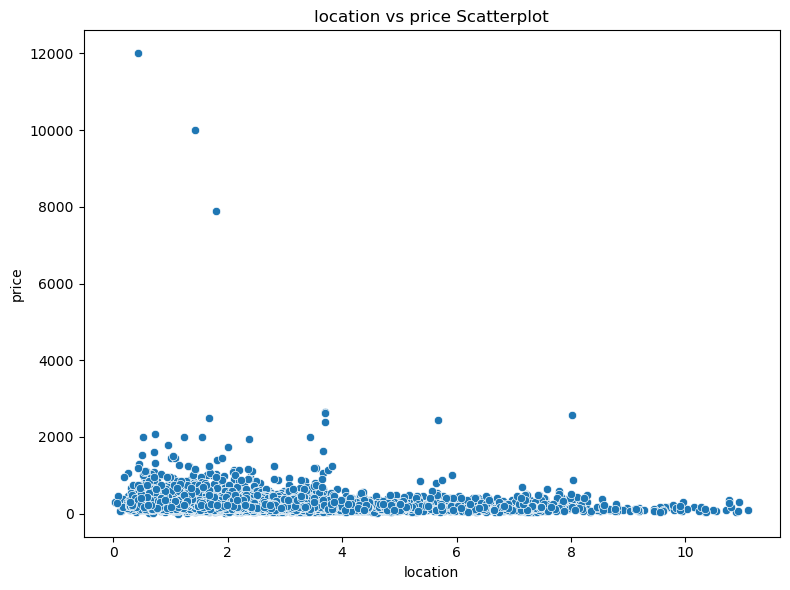

100%|██████████| 7608/7608 [00:03<00:00, 2357.14it/s]


In [29]:
# Price vs. Location
visualize_scatterplot(processed_data, "location", "price")

# **Scatterplot - Availability vs. Location:**

   - There doesn't seem to be a strong correlation between availability and location, indicating that property availability is 
     not significantly influenced by location.
   
   - This information can be useful for tourists or travelers who want to explore areas with a higher availability of 
       properties.

## Benefits:

   - Helps in understanding the distribution of available properties across different locations.
   - Identifies areas with high availability for travelers or tourists.
   - Allows for comparison of property availability in different locations.

## Useful Information:

   - X-axis: Location (measured in kilometers from a reference point).
   - Y-axis: Availability (number of days the property is available for booking in a year).
   - Each point represents a property listing.
   - The scatterplot helps visualize the distribution of availability across different locations.

  0%|          | 0/7608 [00:00<?, ?it/s]

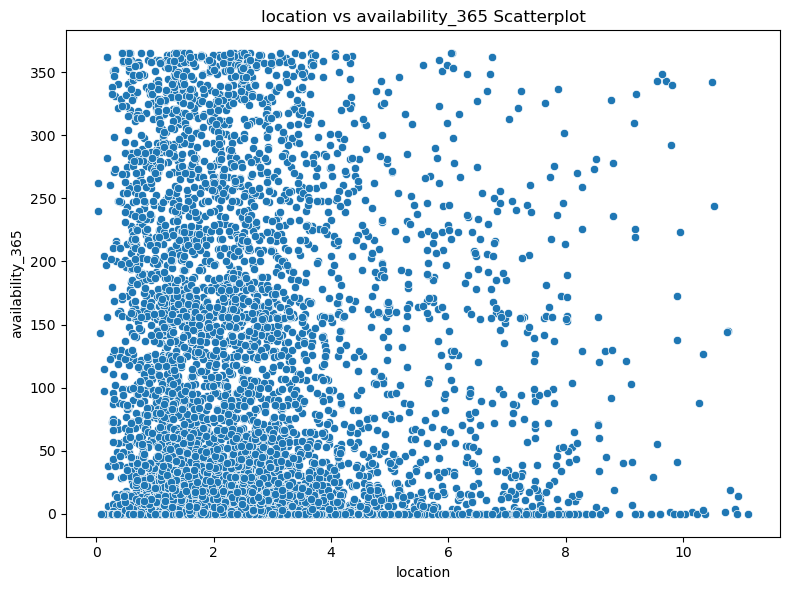

100%|██████████| 7608/7608 [00:00<00:00, 20540.25it/s]


In [30]:
# Availability vs. Location
visualize_scatterplot(processed_data, "location", "availability_365")

# **Pie Chart - Property Type Distribution:**

   - The pie chart represents the distribution of property types among the listings.
   - It shows the percentage of each property type, such as entire homes/apartments, private rooms, and shared rooms.
   - This information can be useful for travelers or renters who want to understand the variety of property types available.

## Benefits:

   - Provides an overview of the property type distribution.
   - Helps in identifying the most common property types.
   - Allows for quick understanding of the diversity of property types available.

## Useful Information:

   - Each slice of the pie chart represents a property type.
   - The percentage value on each slice represents the proportion of that property type in the dataset.
   - The pie chart helps visualize the distribution of property types.



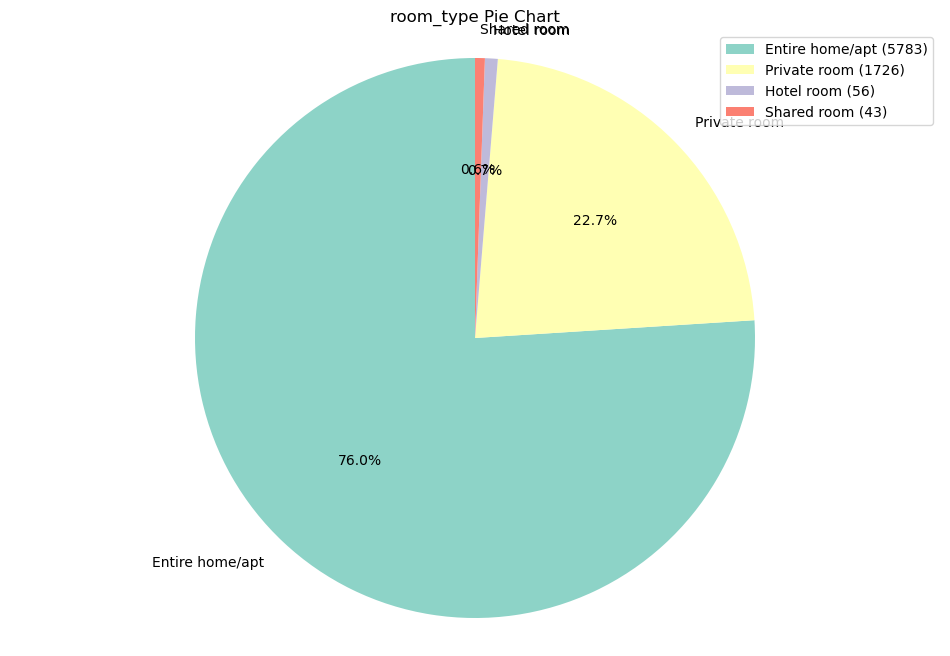

In [58]:
# Property Type Distribution
visualize_pie_chart(processed_data, "room_type")

# **Histogram - Price:**

   - The histogram displays the distribution of property prices.
   - It shows the frequency of different price ranges.
   - This information can be useful for determining the price range of properties in the dataset.

## Benefits:

   - Provides insights into the distribution of property prices.
   - Helps in identifying common price ranges.
   - Allows for a better understanding of the price distribution.

## Useful Information:

   - X-axis: Price (in the local currency).
   - Y-axis: Frequency (number of properties in each price range).
   - The histogram helps visualize the distribution of property prices.


Descriptive statistics for column 'price':
count     7608.000000
mean       251.065589
std        263.170218
min          0.000000
25%        148.000000
50%        202.000000
75%        300.000000
max      12000.000000
Name: price, dtype: float64


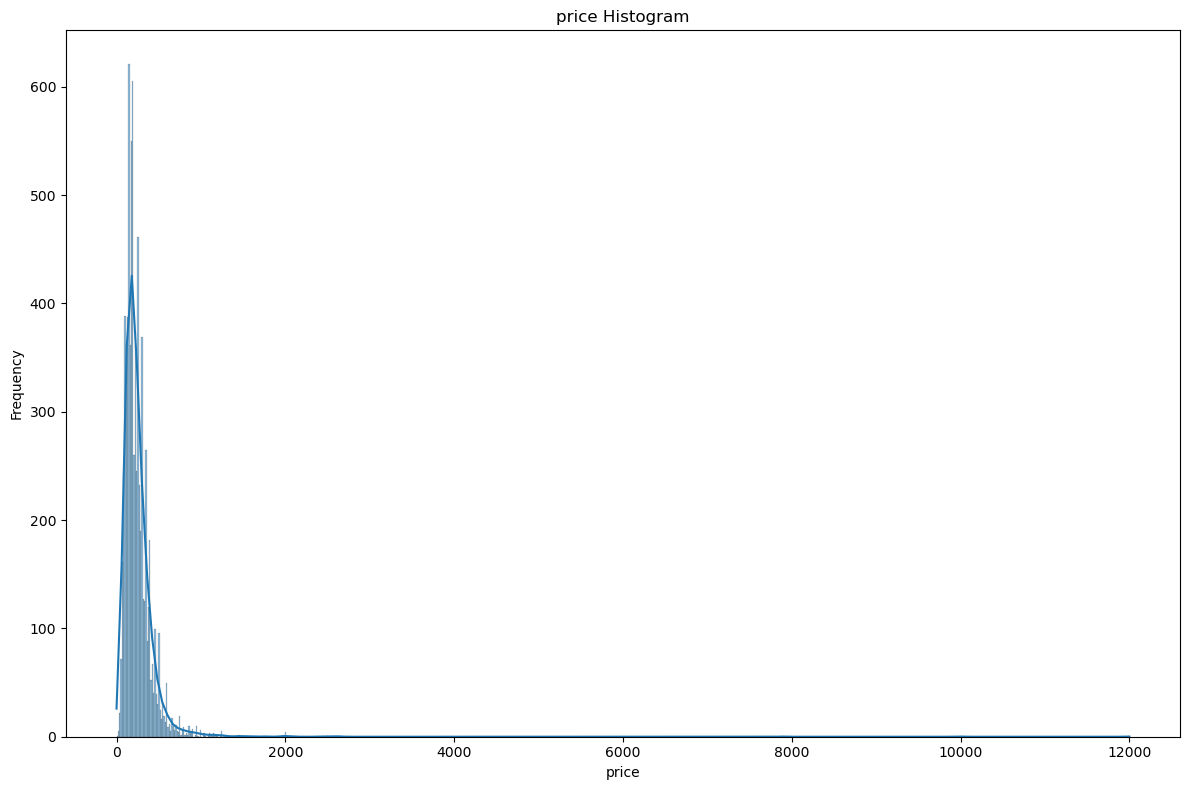

In [37]:
# Histograms
visualize_histogram(processed_data, "price")

# **Histogram - Availability:**

   - The histogram displays the distribution of property availability.
   - It shows the frequency of different availability ranges.
   - This information can be useful for understanding the availability patterns of properties in the dataset.

## Benefits:

   - Provides insights into the distribution of property availability.
   - Helps in identifying common availability ranges.
   - Allows for a better understanding of the availability distribution.

## Useful Information:

   - X-axis: Availability (number of days the property is available for booking in a year).
   - Y-axis: Frequency (number of properties in each availability range).
   - The histogram helps visualize the distribution of property availability.



Descriptive statistics for column 'availability_365':
count    7608.000000
mean       79.586619
std       106.483001
min         0.000000
25%         0.000000
50%        21.000000
75%       145.000000
max       365.000000
Name: availability_365, dtype: float64


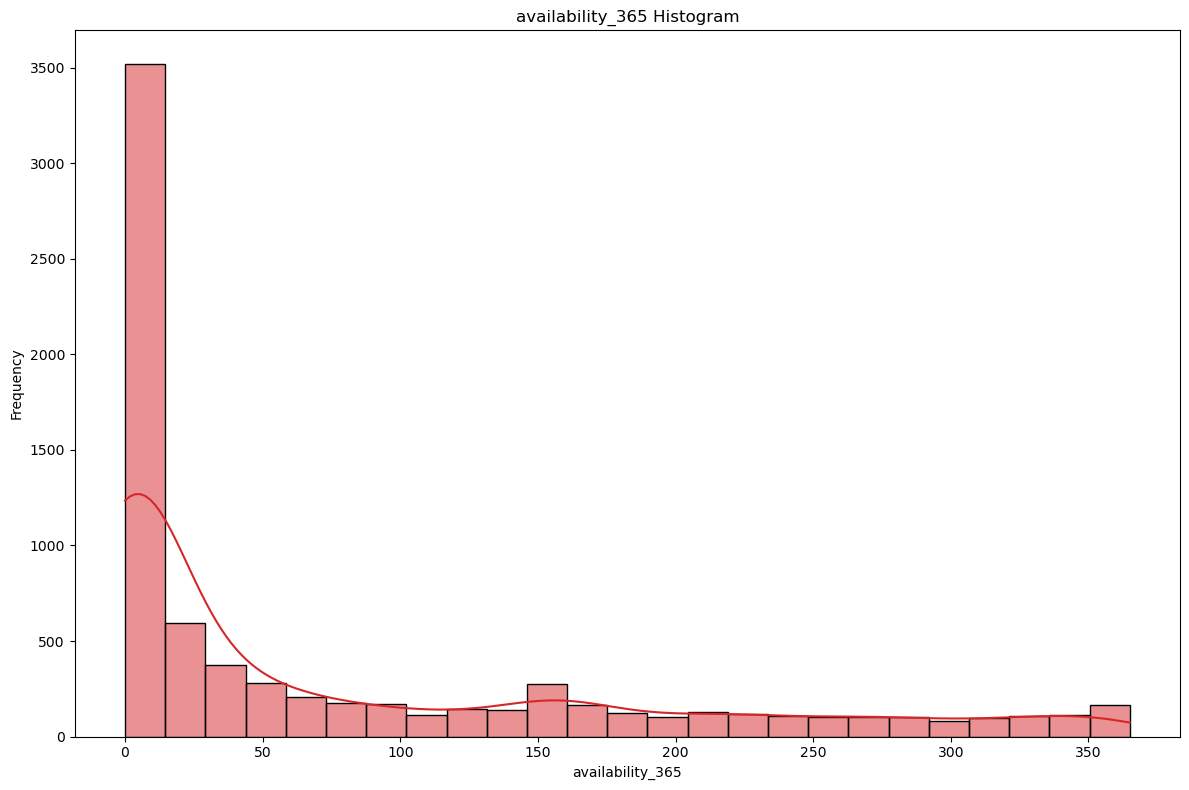

In [33]:
visualize_histogram(processed_data, "availability_365")

# **Histogram - Location:**

   - The histogram displays the distribution of property locations.
   - It shows the frequency of properties in different location ranges.
   - This information can be useful for understanding the concentration of properties in specific areas.

## Benefits:

   - Provides insights into the distribution of property locations.
   - Helps in identifying areas with a higher concentration of properties.
   - Allows for a better understanding of the location distribution.

## Useful Information:

   - X-axis: Location (measured in kilometers from a reference point).
   - Y-axis: Frequency (number of properties in each location range).
   - The histogramhelps visualize the distribution of property locations.


Descriptive statistics for column 'location':
count    7608.000000
mean        2.570013
std         1.644681
min         0.036572
25%         1.445753
50%         2.243541
75%         3.148891
max        11.098962
Name: location, dtype: float64


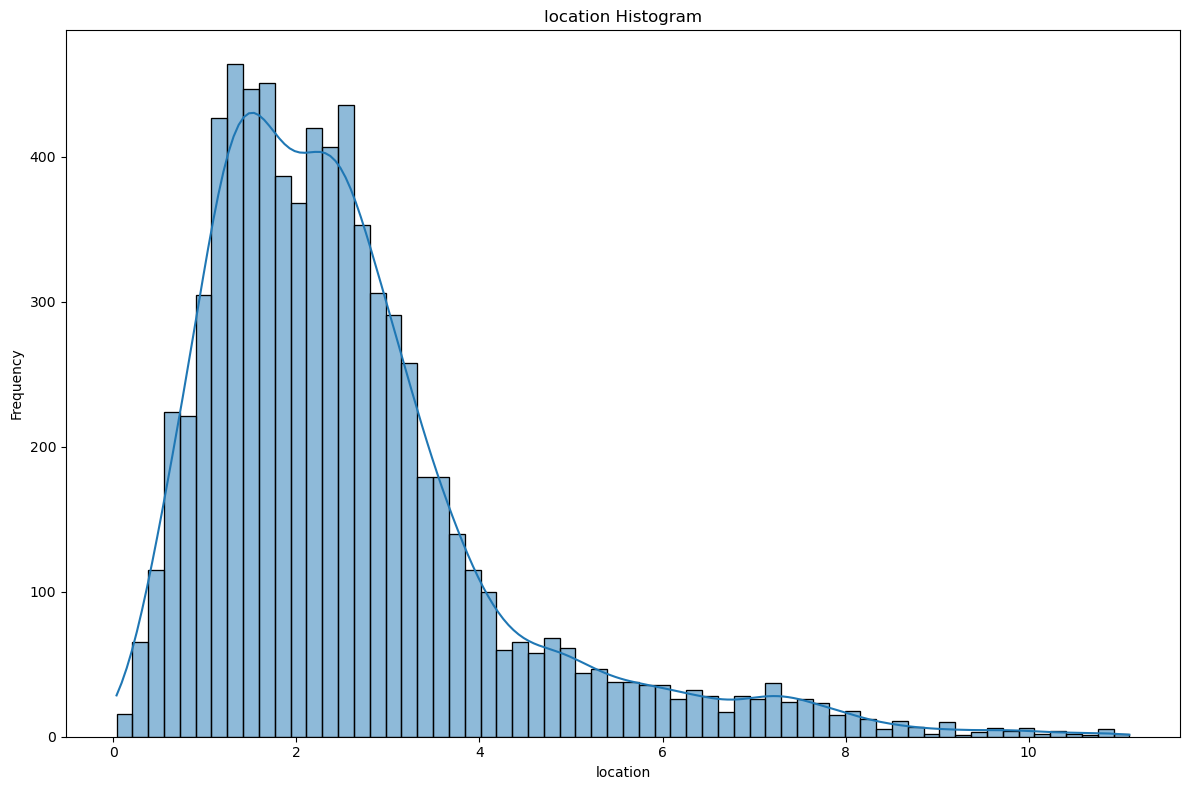

In [34]:
visualize_histogram(processed_data, "location")

# **Histogram - Room Type**

## Insights:

- The histogram displays the distribution of property listings based on room types. It shows the frequency of properties in different room type categories. This information can be useful for understanding the distribution and popularity of different room types in the dataset.

## Benefits:

- Provides insights into the distribution of property listings based on room types.
- Helps in identifying the most common room types in the dataset.
- Allows for a better understanding of the popularity and availability of different room types.

## Useful Information:

- X-axis: Room Type (categories such as "Entire Home", "Private Room", "Shared Room").
- Y-axis: Frequency (number of properties in each room type category).
- The histogram helps visualize the distribution of property listings based on room types.

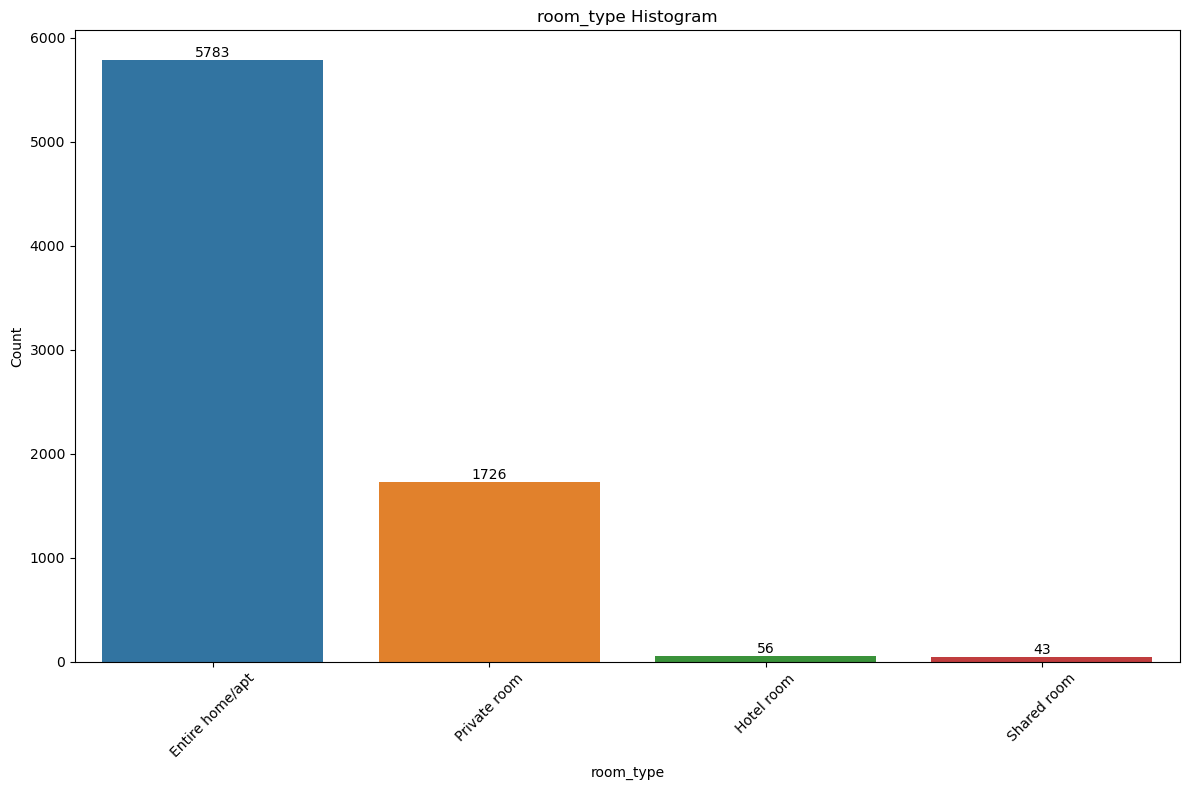


Value counts for column 'room_type':
Entire home/apt    5783
Private room       1726
Hotel room           56
Shared room          43
Name: room_type, dtype: int64


In [38]:
visualize_histogram(processed_data, "room_type")

# **Scatterplot - Availability vs. Room Type:**

- There appears to be a relationship between room type and availability, indicating that the type of room offered significantly affects the availability of properties.
- This information can be valuable for travelers or tourists in search of specific room types with higher availability.

## Insights:

- Different room types exhibit varying levels of availability, suggesting differences in demand or booking patterns.
- Certain room types may have higher availability throughout the year, while others might be more limited in terms of availability.
- Analyzing the availability by room type can help individuals make informed decisions based on their preferences and requirements.

## Benefits:

- Provides an understanding of how availability varies across different room types.
- Helps identify room types that are consistently available or in high demand.
- Allows travelers to select room types based on availability and personal preferences.

## Useful Information:

- X-axis: Room Type (categories of room types, such as "Entire home/apartment," "Private room," "Shared room," etc.).
- Y-axis: Availability (number of days the property is available for booking in a year).
- Each point on the scatterplot represents a property listing.
- The scatterplot enables visualizing the relationship between room type and availability.

  0%|          | 0/7608 [00:00<?, ?it/s]C:\Users\husse\AppData\Local\Temp\ipykernel_1700\3595019496.py:24: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(


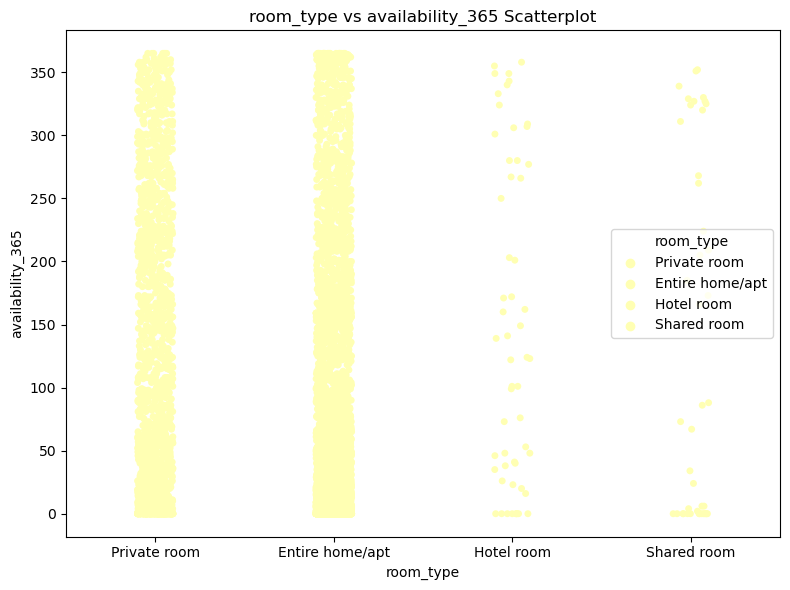

100%|██████████| 7608/7608 [00:00<00:00, 9329.93it/s]


In [60]:
visualize_scatterplot(data, "room_type", "availability_365")

# **Recommendation Analysis:**

- Based on our analysis of the current situation, we recommend implementing the following strategies to optimize pricing and room availability for different locations:

1. Pricing Adjustments for Nearest Locations:
    We propose increasing the prices for the nearest locations where there is high demand and a limited number of available rooms. By raising the prices in these areas, we can capitalize on the scarcity of rooms and maximize revenue. This approach ensures that customers who prioritize proximity are willing to pay a premium for the convenience.

2. Pricing Adjustments for Remote Locations:
    Conversely, we suggest decreasing the prices for rooms in remote locations where demand is relatively low and the number of available rooms exceeds demand. By offering competitive rates in these areas, we can attract more customers and increase occupancy rates. Lowering the prices for remote rooms allows us to leverage the surplus availability and generate revenue that would otherwise be missed.

3. Expansion of Hotel and Shared Rooms:
    To meet the growing demand, we recommend increasing the number of hotel and shared rooms available. This expansion should be carried out in conjunction with a strategic pricing approach. As the number of rooms increases, we can gradually adjust the prices upwards to maintain profitability. This strategy allows us to capitalize on the increased capacity while ensuring that the prices remain reasonable and competitive.

- By implementing these recommendations, we aim to achieve the following objectives:

1. Maximizing Revenue: By adjusting prices based on demand and availability, we can optimize revenue generation by capitalizing on both high-demand and low-demand locations.
2. Increasing Occupancy: By offering competitive pricing in remote locations, we can attract more customers and improve occupancy rates, maximizing the utilization of available rooms.
3. Meeting Customer Needs: Expanding the number of hotel and shared rooms will allow us to accommodate a larger customer base and cater to their diverse preferences and budgets.

#### It is important to regularly monitor market conditions, customer feedback, and competitor strategies to fine-tune the pricing and room allocation strategies. Additionally, employing data-driven approaches, such as leveraging historical booking data and conducting regular market analysis, can further enhance the effectiveness of these recommendations.

#### By adopting these professional strategies, we aim to optimize pricing and room availability, ultimately contributing to the overall success and profitability of our hotel business.